<a href="https://colab.research.google.com/github/jshinm/code_bucket/blob/main/Modified_autoencoder_EEG.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# LAB 8: Representation learning with Autoencoders

In this lab, we will solve a 3-class classification problem using Epilespy EEG data called Bonn.
The three classes are defined by Table 3 (case 6) of this paper:
https://www.sciencedirect.com/science/article/pii/S0957417420306114

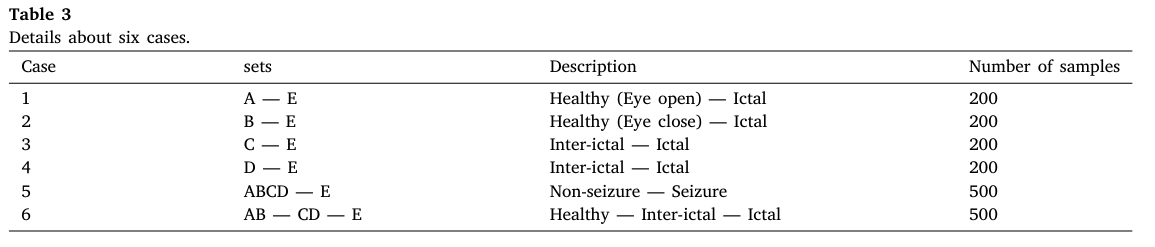

This dataset contains five subsets defined as (A–E); each subset contains 100 single-channel EEG segments with the time span of 23.6 s, and each segment contains 4097 signal samples. The sampling rate and resolution are 173.61 Hz and 12 bits, respectively. Subsets A and B are normal signals with open and closed eyes, subsets C and D indicated as intermittent data are related to the preictal phases, and subset E, as ictal data contains epileptic seizures.

In this lab, class#1 ("normal") = setA+setB; class#2 ("Inter-ictal") = setC+setD; class#3 ("Ictal") = setE


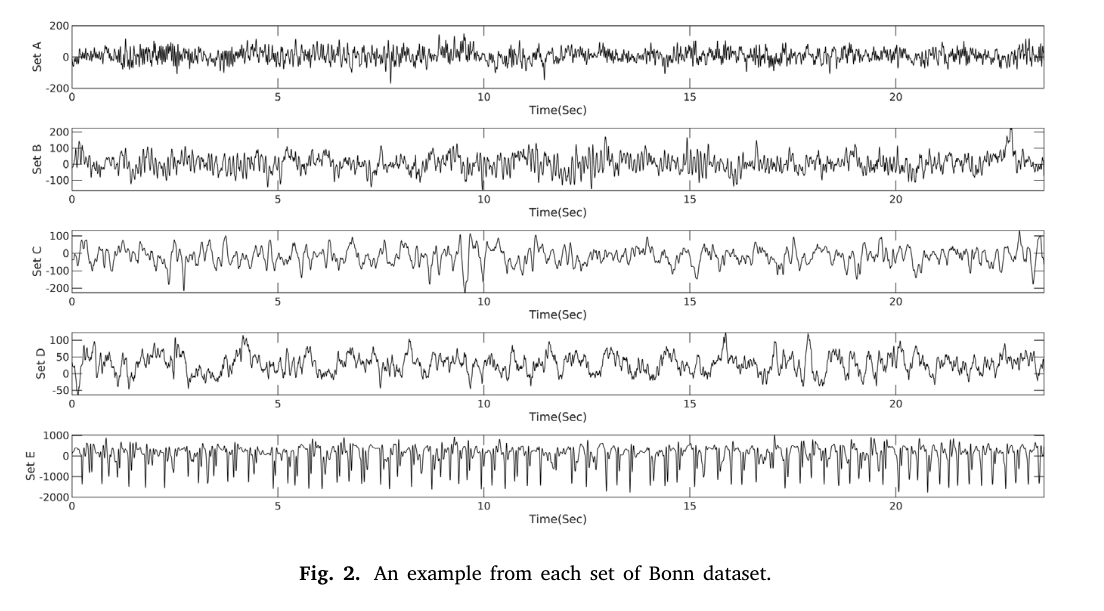

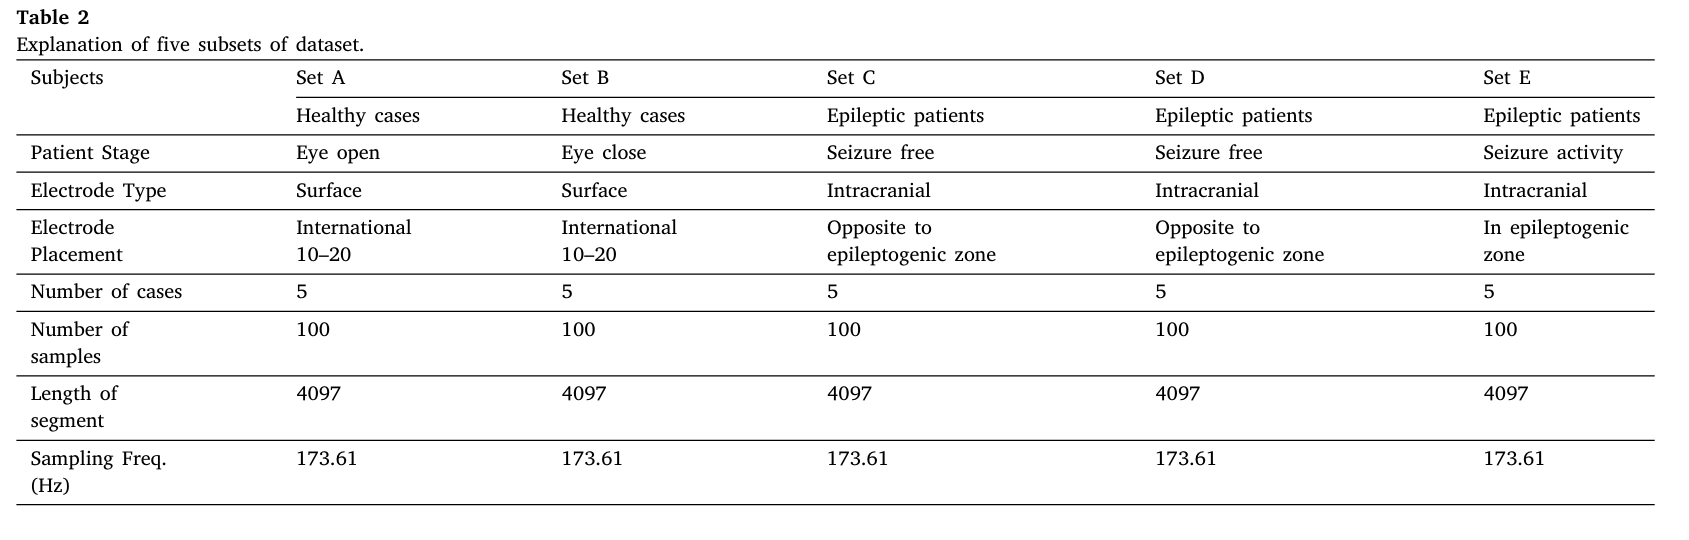

At the bottom of this web page: (http://epileptologie-bonn.de/cms/front_content.php?idcat=193&lang=3), you will find the links to download 5 zip files corresponding to five "sets" of data (A-E).

In [415]:
# load libraries; feel free to add more
import numpy as np
import os
import math
import matplotlib.pyplot as plt
from google.colab import drive
from sklearn.model_selection import train_test_split

import keras

In [416]:
import pandas as pd
from zipfile import ZipFile

#imports for keras and sklearn
from keras_preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Conv1D, MaxPool1D, BatchNormalization, UpSampling1D, ZeroPadding1D, Dense, Flatten, Dropout, ReLU # https://keras.io/api/layers/convolution_layers/convolution1d/
from keras.regularizers import L1, L2
from keras.utils import to_categorical

from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

**TASK 1 (10 points): (Data Preparation)** Load all EEG files into data matrix X (NxS) and label vector y (Nx1). N should be around 2000 for this lab. A single data point corresponds to a contiguous S=868 sample length (~5 sec) from an EEG file. These 5 second segments are non-overlapping portions from the datasets.

The labels should be 0, 1, or 2. If you choose to store labels in other format like "one-hot encoding", y.shape would be Nx3.

Next, normalize all data to range of [-1,1] and split it into 9:1 proportion to construct training and testing portion.

In [417]:
# data preparation CODE HERE

In [418]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [419]:
DIRPATH = '/content/drive/MyDrive/JHU_NDD/fiveset/'
DPATH = 'dataset'
DIC = dict(Z=0, O=0, N=1, F=1, S=2)

# SET A	Z.zip 	with	Z000.txt - Z100.txt	(564 kB)
# SET B 	O.zip	with	O000.txt - O100.txt	(611 kB)
# SET C	N.zip 	with	N000.txt - N100.txt 	(560 kB)
# SET D	F.zip  	with	F000.txt - F100.txt 	(569kB)
# SET E	S.zip 	with	S000.txt - S100.txt 	(747kB)

In [420]:
for dirpath, dir, files in os.walk(DIRPATH):
    for f in files:
        temp = dirpath + '/' + f
        with ZipFile(temp, 'r') as zipobj:
            zipobj.extractall(DPATH)

In [422]:
def normalize(d):
    # d = (d - min(d)) / (max(d) - min(d))
    d = d / max(abs(d))
    return d

In [827]:
df_X = pd.DataFrame()
df_y = pd.DataFrame()

for f in os.listdir(DPATH):
    with open(DPATH + '/' + f,'r') as fobj:
        tempL = normalize(np.array(list(fobj)[:4000]).astype(int)).T
        df_X[f] = tempL
        df_y[f] = [DIC[f[0]]]

In [828]:
df_X

,O044.txt,O082.txt,Z003.txt,N060.TXT,N011.TXT,F099.txt,S040.txt,O060.txt,S051.txt,Z077.txt,F088.txt,N033.TXT,Z066.txt,F065.txt,N017.TXT,Z036.txt,O046.txt,N047.TXT,F087.txt,N029.TXT,Z078.txt,O070.txt,Z029.txt,F062.txt,F016.txt,F026.txt,S010.txt,Z083.txt,Z063.txt,N043.TXT,N087.TXT,F089.txt,Z044.txt,F091.txt,N010.TXT,F027.txt,S033.txt,F029.txt,N083.TXT,S053.txt,...,Z042.txt,Z043.txt,S006.txt,N086.TXT,F038.txt,F001.txt,N077.TXT,O075.txt,F054.txt,Z072.txt,Z076.txt,O030.txt,S085.txt,O023.txt,N056.TXT,S078.txt,Z056.txt,F022.txt,S002.txt,O019.txt,Z059.txt,O043.txt,O007.txt,Z001.txt,Z032.txt,Z075.txt,S074.txt,N095.TXT,N018.TXT,Z019.txt,S009.txt,S059.txt,S013.txt,O050.txt,S023.txt,F094.txt,O058.txt,F060.txt,S063.txt,Z087.txt
0,0.102564,0.446602,-0.201087,-0.184438,0.290598,0.048077,0.486301,0.337553,0.168966,0.247826,-0.047619,-0.121495,-0.151515,0.224670,-0.413793,0.204082,0.262745,0.065134,0.423913,-0.189744,-0.046784,0.049057,-0.207921,-0.086643,-0.538889,-0.031579,0.198408,-0.307692,-0.325203,-0.438679,0.025424,0.139610,-0.272189,0.340206,-0.297101,-0.084677,0.190308,0.042386,-0.398734,0.121429,...,-0.515924,-0.154472,-0.195122,-0.021583,-0.095238,0.276423,0.071429,0.486339,-0.183333,0.672619,0.221591,-0.145833,0.105747,0.026596,-0.100000,-0.389011,0.272189,0.104,0.187225,0.046358,-0.140845,0.012658,-0.179931,0.063158,-0.450549,0.142857,-0.054688,0.158333,0.208633,0.000000,-0.309270,-0.310210,0.489823,-0.208333,0.032143,-0.196172,-0.199187,0.141238,0.427481,-0.014388
1,0.153846,0.533981,-0.119565,-0.161383,0.264957,0.019231,0.613014,0.232068,0.151724,0.356522,0.000000,-0.098131,-0.232323,0.167401,-0.482759,0.306122,0.364706,0.084291,0.445652,-0.179487,-0.111111,-0.052830,-0.242574,-0.054152,-0.505556,-0.031579,-0.108753,-0.302198,-0.268293,-0.466981,0.025424,0.214286,-0.260355,0.391753,-0.253623,-0.060484,0.160352,0.045526,-0.386076,0.127551,...,-0.503185,0.073171,-0.254989,0.028777,-0.152381,0.268293,-0.059006,0.311475,-0.196667,0.767857,0.232955,-0.154167,-0.091954,-0.159574,-0.124138,-0.520879,0.248521,0.116,0.194383,0.009934,-0.161972,0.012658,-0.193772,0.115789,-0.406593,0.059524,-0.044271,0.233333,0.194245,0.018349,-0.310911,-0.279922,0.454366,-0.173611,0.065476,-0.196172,-0.130081,0.142982,0.379771,-0.057554
2,0.256410,0.500000,-0.092391,-0.149856,0.247863,-0.057692,0.208904,0.063291,0.131034,0.404348,0.079365,-0.037383,-0.252525,0.149780,-0.536050,0.377551,0.439216,0.072797,0.445652,-0.205128,-0.187135,-0.188679,-0.183168,-0.018051,-0.411111,-0.073684,-0.462069,-0.291209,-0.130081,-0.495283,0.050847,0.331169,-0.278107,0.419244,-0.202899,0.008065,0.128634,0.048666,-0.379747,0.131633,...,-0.484076,0.284553,-0.310421,0.129496,-0.166667,0.227642,-0.226708,0.120219,-0.213333,0.642857,0.244318,-0.133333,-0.327011,-0.297872,-0.175862,-0.584615,0.171598,0.104,0.220264,-0.046358,-0.169014,0.056962,-0.169550,0.184211,-0.318681,-0.053571,-0.041667,0.312500,0.143885,-0.009174,-0.324856,-0.256473,0.369009,-0.083333,0.089286,-0.229665,-0.150407,0.142982,0.284351,-0.194245
3,0.314103,0.310680,-0.130435,-0.190202,0.162393,-0.038462,-0.195205,0.118143,0.101724,0.295652,0.063492,0.028037,-0.232323,0.211454,-0.636364,0.357143,0.486275,0.080460,0.456522,-0.158974,-0.233918,-0.264151,-0.059406,-0.003610,-0.294444,-0.031579,-0.702918,-0.318681,0.121951,-0.410377,0.101695,0.451299,-0.236686,0.453608,-0.166667,0.076613,0.112775,0.047096,-0.335443,0.136735,...,-0.420382,0.300813,-0.352550,0.172662,-0.247619,0.178862,-0.338509,0.098361,-0.256667,0.357143,0.204545,-0.087500,-0.435632,-0.430851,-0.172414,-0.628571,0.118343,0.088,0.258811,-0.089404,-0.169014,0.139241,-0.176471,0.236842,-0.406593,-0.107143,-0.039062,0.354167,0.071942,0.128440,-0.367514,-0.284319,0.262640,0.118056,0.107143,-0.229665,-0.158537,0.134263,0.127863,-0.309353
4,0.352564,0.228155,-0.168478,-0.181556,0.136752,-0.086538,-0.532534,0.113924,0.068966,0.100000,0.095238,0.130841,-0.181818,0.229075,-0.583072,0.341837,0.403922,0.038314,0.467391,-0.123077,-0.321637,-0.407547,0.000000,0.01

In [829]:
df_y

,O044.txt,O082.txt,Z003.txt,N060.TXT,N011.TXT,F099.txt,S040.txt,O060.txt,S051.txt,Z077.txt,F088.txt,N033.TXT,Z066.txt,F065.txt,N017.TXT,Z036.txt,O046.txt,N047.TXT,F087.txt,N029.TXT,Z078.txt,O070.txt,Z029.txt,F062.txt,F016.txt,F026.txt,S010.txt,Z083.txt,Z063.txt,N043.TXT,N087.TXT,F089.txt,Z044.txt,F091.txt,N010.TXT,F027.txt,S033.txt,F029.txt,N083.TXT,S053.txt,...,Z042.txt,Z043.txt,S006.txt,N086.TXT,F038.txt,F001.txt,N077.TXT,O075.txt,F054.txt,Z072.txt,Z076.txt,O030.txt,S085.txt,O023.txt,N056.TXT,S078.txt,Z056.txt,F022.txt,S002.txt,O019.txt,Z059.txt,O043.txt,O007.txt,Z001.txt,Z032.txt,Z075.txt,S074.txt,N095.TXT,N018.TXT,Z019.txt,S009.txt,S059.txt,S013.txt,O050.txt,S023.txt,F094.txt,O058.txt,F060.txt,S063.txt,Z087.txt
0,0,0,0,1,1,1,2,0,2,0,1,1,0,1,1,0,0,1,1,1,0,0,0,1,1,1,2,0,0,1,1,1,0,1,1,1,2,1,1,2,...,0,0,2,1,1,1,1,0,1,0,0,0,2,0,1,2,0,1,2,0,0,0,0,0,0,0,2,1,1,0,2,2,2,0,2,1,0,1,2,0


In [846]:
def binning(dat, s):
    N = len(dat)
    newdat = []
    for i in range(0, N, s):
        newdat.append(dat[i:i+5])

    return newdat

In [834]:
df_X.to_numpy()[:,0].shape

(4000,)

In [847]:
temp = binning(df_X.to_numpy()[:,0], 5)

In [857]:
np.array(temp)
new_df_X = []

for i in df_X:
    new_df_X.append(binning(df_X[i].to_numpy(), 5))

new_df_X = np.array(new_df_X)

In [858]:
new_df_X.shape, df_y.T.shape

((500, 800, 5), (500, 1))

In [859]:
train_X, test_X, train_y, test_y = train_test_split(new_df_X, df_y.T, test_size=0.1, random_state=12345, shuffle=True)

In [860]:
train_X.shape, test_X.shape, train_y.shape, test_y.shape

((450, 800, 5), (50, 800, 5), (450, 1), (50, 1))

**TASK 2 (15 points): (Auto-encoder training)** Using Keras, create and train the auto-encoder specified in the paper.
An autoencoder is a specific type of a neural network, which is mainly designed to encode the input into a compressed and meaningful representation, and then decode it back such that the reconstructed input is similar as possible to the original one.
We will refer to this model as *original auto-encoder* in this lab.
We provide the Table 9 from the paper which specifies all details of the network below. Choose MSE (mean squared error) as loss function.
Your loss must decrease with epochs.

Hint 1: It would be useful to use `print(autoencoder.summary())` to verify if your architecture is correct.

Hint 2: Convolutional layers need to be modified such that they do not modify the length of input signal. Also, ensure the output of network is same shape as input.

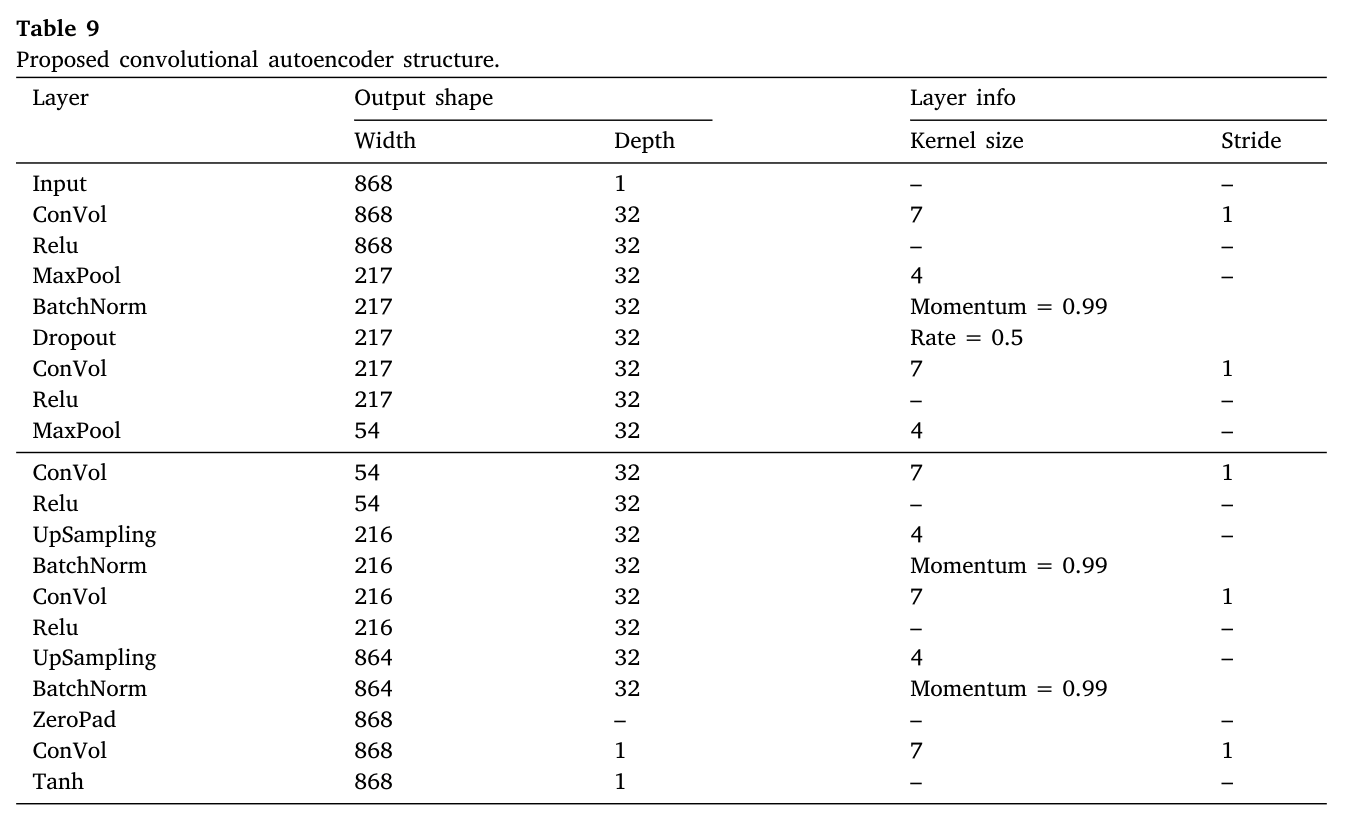

In [861]:
# Custom CNN Model (There are 3 Conv-MaxPool operations)
firstAct = 'relu'

model = Sequential()
model.add(Conv1D(32,(7), strides=1, padding='same', activation=firstAct))
model.add(MaxPool1D(4,padding='same'))
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Conv1D(32,(7), strides=1, padding='same', activation=firstAct))
model.add(MaxPool1D(4,padding='same'))

model.add(Conv1D(32,(7), strides=1, padding='same', activation=firstAct))
model.add(UpSampling1D(4))
model.add(BatchNormalization())

model.add(Conv1D(32,(7), strides=1, padding='same', activation=firstAct))
model.add(UpSampling1D(4))
model.add(BatchNormalization())
# model.add(ZeroPadding1D(2))

model.add(Conv1D(1,(7), strides=1, padding='same', activation='tanh'))
# model.add(keras.layers.Activation(keras.activations.tanh))

model.compile(optimizer='adam', loss='mse', metrics=['accuracy'])

In [866]:
tempX = train_X
tempy = train_y.T.to_numpy()[np.newaxis,:].T

tempX.shape, tempy.shape

((450, 800, 5), (450, 1, 1))

In [887]:
model_history = model.fit(tempX, tempX, epochs=100)

Epoch 1/100
2/2 [==============================] - 0s 14ms/step - loss: 0.1063 - accuracy: 0.0067
Epoch 2/100
2/2 [==============================] - 0s 12ms/step - loss: 0.0948 - accuracy: 0.0067
Epoch 3/100
2/2 [==============================] - 0s 12ms/step - loss: 0.1046 - accuracy: 0.0069
Epoch 4/100
2/2 [==============================] - 0s 13ms/step - loss: 0.1066 - accuracy: 0.0067
Epoch 5/100
2/2 [==============================] - 0s 12ms/step - loss: 0.0946 - accuracy: 0.0068
Epoch 6/100
2/2 [==============================] - 0s 12ms/step - loss: 0.0994 - accuracy: 0.0067
Epoch 7/100
2/2 [==============================] - 0s 12ms/step - loss: 0.0990 - accuracy: 0.0068
Epoch 8/100
2/2 [==============================] - 0s 15ms/step - loss: 0.0895 - accuracy: 0.0068
Epoch 9/100
2/2 [==============================] - 0s 12ms/step - loss: 0.1083 - accuracy: 0.0067
Epoch 10/100
2/2 [==============================] - 0s 13ms/step - loss: 0.0999 - accuracy: 0.0069
Epoch 11/100
2/2 [=

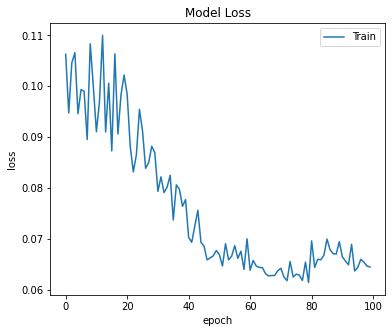

In [893]:
fig, axs = plt.subplots(1,1, figsize=(6,5))

axs.plot(model_history.history['loss'], label='Train')
axs.set_title('Model Loss')
axs.set_ylabel('loss')
axs.set_xlabel('epoch')
axs.legend()

In [894]:
model.summary()

Model: "sequential_55"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_221 (Conv1D)          (None, 800, 32)           1152      
_________________________________________________________________
max_pooling1d_108 (MaxPoolin (None, 200, 32)           0         
_________________________________________________________________
batch_normalization_130 (Bat (None, 200, 32)           128       
_________________________________________________________________
dropout_54 (Dropout)         (None, 200, 32)           0         
_________________________________________________________________
conv1d_222 (Conv1D)          (None, 200, 32)           7200      
_________________________________________________________________
max_pooling1d_109 (MaxPoolin (None, 50, 32)            0         
_________________________________________________________________
conv1d_223 (Conv1D)          (None, 50, 32)          

In [895]:
tempX = test_X
tempy = test_y.T.to_numpy()[np.newaxis,:].T

tempX.shape, tempy.shape

((50, 800, 5), (50, 1, 1))

In [896]:
_, acc = model.evaluate(tempX, tempX, verbose=True)
print(f'Test Accuracy: {acc * 100}')

2/2 [==============================] - 0s 8ms/step - loss: 0.0653 - accuracy: 0.0071
Test Accuracy: 0.7149999961256981


**TASK 3 (10 points): (Visualization of reconstruction)** Let x be a 868-sample long data point from your test set, e() be encoder, d() be decoder. The reconstuction/auto-encoding of x is given by d(e(x)) i.e. simply forward pass of x through the auto-encoder. On separate figures, (1) plot one signal from test set and its reconstructed version.

Also, answer the following questions:
(2) What is the dimension of encoding $z$ (learned representation) of x? If you find the encoding $z$ to be multi-dimensional i.e. `len(z.shape) > 1`, then the encoding dimension is defined as `np.prod(z.shape)`
 (3) Comment on the relation between the obtained dimension of learned representation and reconstructed signal quality.

In [878]:
tempX[0:1].shape

(1, 800, 5)

In [885]:
# visualization of reconstruction CODE HERE
idx = [2]

predX = model.predict(tempX[idx])

Text(0.5, 1.0, 'Prediction')

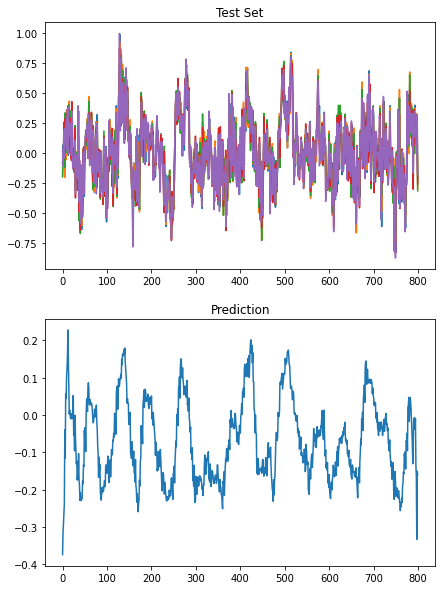

In [886]:
fig, axs = plt.subplots(2,1,figsize=(7,5*2))

axs[0].plot(tempX[idx][0])
axs[1].plot(predX[0])

axs[0].set_title('Test Set')
axs[1].set_title('Prediction')

The dimension of the encoding (learned representation) seems to be 25600 as calculated below.

In [898]:
if len(model.get_layer('conv1d_221').output.shape) > 1:
    print(np.prod(model.get_layer('conv1d_221').output.shape[1:]))

25600


In terms of the relationship between the obtained dimension of learned representation and reconstructed signal quality, the more dimensions we pick, the more detail we will be able to express, but if we choose the number of dimensions too large, we might unnecessarily have too much data and memory and computation requirements to deal with. If we choose the number of dimensions too small, we will lose detail. The right number of dimensions completely depends on the problem we’re trying to solve.

Excerpted from https://medium.com/artists-and-machine-intelligence/a-journey-through-multiple-dimensions-and-transformations-in-space-the-final-frontier-d8435d81ca51

**TASK 4 (15 points) (Training classifier)**: Discarding the decoder, append a simple classifier at the end of your trained encoder. The classifier (excluding your encoder) is a M=100 unit dense layer followed by your favorite activation function followed by 3-class softmax classification. Encoder must be frozen in this training. Report accuracy on test set.

In [899]:
model2 = keras.models.clone_model(model) #save trained model

In [993]:
model = keras.models.clone_model(model2)

In [994]:
# training classifier CODE HERE
firstAct = 'relu'

model_softmax = Sequential()

model_softmax.add(Conv1D(32,(7), strides=1, padding='same', activation=firstAct))
model_softmax.add(MaxPool1D(4,padding='same'))
model_softmax.add(BatchNormalization())
model_softmax.add(Dropout(0.5))

model_softmax.add(Conv1D(32,(7), strides=1, padding='same', activation=firstAct))
model_softmax.add(MaxPool1D(4,padding='same'))

# following layers to be added after weight transfer
# model_softmax.add(Dense(100, activation='relu'))
# model_softmax.add(Dense(3, activation='softmax'))

model_softmax.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [995]:
model.input_shape

(None, 800, 5)

In [996]:
model_softmax.build(model.input_shape) #building model to allow for weight transfer

In [997]:
# get rid of decoder from the autoencoder
for i in range(7):
    model._layers.pop(-1)

for i in model.trainable_weights:
    print(i.name)

conv1d_221/kernel:0
conv1d_221/bias:0
batch_normalization_130/gamma:0
batch_normalization_130/beta:0
conv1d_222/kernel:0
conv1d_222/bias:0


In [998]:
# check to make sure we have the same layer remaining
for i in model.trainable_weights:
    print(i.name)

print('-----')

for i in model_softmax.trainable_weights:
    print(i.name)    

print('-----\n')
print('-----')

print(len(model.get_weights()), len(model_softmax.get_weights()))

conv1d_221/kernel:0
conv1d_221/bias:0
batch_normalization_130/gamma:0
batch_normalization_130/beta:0
conv1d_222/kernel:0
conv1d_222/bias:0
-----
conv1d_230/kernel:0
conv1d_230/bias:0
batch_normalization_135/gamma:0
batch_normalization_135/beta:0
conv1d_231/kernel:0
conv1d_231/bias:0
-----

-----
8 8


In [999]:
# transfer weights
model_softmax.set_weights(model.get_weights())

In [1000]:
model.summary()

Model: "sequential_55"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_221 (Conv1D)          (None, 800, 32)           1152      
_________________________________________________________________
max_pooling1d_108 (MaxPoolin (None, 200, 32)           0         
_________________________________________________________________
batch_normalization_130 (Bat (None, 200, 32)           128       
_________________________________________________________________
dropout_54 (Dropout)         (None, 200, 32)           0         
_________________________________________________________________
conv1d_222 (Conv1D)          (None, 200, 32)           7200      
_________________________________________________________________
max_pooling1d_109 (MaxPoolin (None, 50, 32)            0         
Total params: 8,480
Trainable params: 8,416
Non-trainable params: 64
__________________________________________________

In [1001]:
model_softmax.summary()

Model: "sequential_58"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_230 (Conv1D)          (None, 800, 32)           1152      
_________________________________________________________________
max_pooling1d_114 (MaxPoolin (None, 200, 32)           0         
_________________________________________________________________
batch_normalization_135 (Bat (None, 200, 32)           128       
_________________________________________________________________
dropout_57 (Dropout)         (None, 200, 32)           0         
_________________________________________________________________
conv1d_231 (Conv1D)          (None, 200, 32)           7200      
_________________________________________________________________
max_pooling1d_115 (MaxPoolin (None, 50, 32)            0         
Total params: 8,480
Trainable params: 8,416
Non-trainable params: 64
__________________________________________________

In [1002]:
# freeze encoder layers
for layer in model_softmax.layers:
    layer.trainable = False

In [1003]:
# add classifier
model_softmax.add(Flatten())
model_softmax.add(Dense(100, activation='sigmoid'))
model_softmax.add(Dense(3, activation='softmax'))

model_softmax.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [1004]:
model_softmax.summary()

Model: "sequential_58"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_230 (Conv1D)          (None, 800, 32)           1152      
_________________________________________________________________
max_pooling1d_114 (MaxPoolin (None, 200, 32)           0         
_________________________________________________________________
batch_normalization_135 (Bat (None, 200, 32)           128       
_________________________________________________________________
dropout_57 (Dropout)         (None, 200, 32)           0         
_________________________________________________________________
conv1d_231 (Conv1D)          (None, 200, 32)           7200      
_________________________________________________________________
max_pooling1d_115 (MaxPoolin (None, 50, 32)            0         
_________________________________________________________________
flatten_17 (Flatten)         (None, 1600)            

In [1005]:
tempX = train_X
tempy = train_y.T.to_numpy()[np.newaxis,:].T
tempy = to_categorical(tempy).reshape(450,3) #one hot encode to match the softmax layer

tempX.shape, tempy.shape

((450, 800, 5), (450, 3))

In [1006]:
model_softmax.fit(tempX, tempy, epochs=50)

Epoch 1/50
15/15 [==============================] - 1s 3ms/step - loss: 1.1884 - accuracy: 0.3370
Epoch 2/50
15/15 [==============================] - 0s 3ms/step - loss: 0.9796 - accuracy: 0.4657
Epoch 3/50
15/15 [==============================] - 0s 3ms/step - loss: 0.9527 - accuracy: 0.5052
Epoch 4/50
15/15 [==============================] - 0s 4ms/step - loss: 0.8899 - accuracy: 0.5813
Epoch 5/50
15/15 [==============================] - 0s 3ms/step - loss: 0.8606 - accuracy: 0.6151
Epoch 6/50
15/15 [==============================] - 0s 4ms/step - loss: 0.8234 - accuracy: 0.7507
Epoch 7/50
15/15 [==============================] - 0s 3ms/step - loss: 0.7671 - accuracy: 0.7231
Epoch 8/50
15/15 [==============================] - 0s 3ms/step - loss: 0.7832 - accuracy: 0.7442
Epoch 9/50
15/15 [==============================] - 0s 3ms/step - loss: 0.7015 - accuracy: 0.8121
Epoch 10/50
15/15 [==============================] - 0s 3ms/step - loss: 0.7019 - accuracy: 0.7361
Epoch 11/50
15/15 [

In [1007]:
tempX = test_X
tempy = test_y.T.to_numpy()[np.newaxis,:].T
tempy = to_categorical(tempy).reshape(50,3) #one hot encode test labels

tempX.shape, tempy.shape

((50, 800, 5), (50, 3))

In [1009]:
_, acc = model_softmax.evaluate(tempX, tempy, verbose=True)
print(f'Test Accuracy: {acc * 100}')

2/2 [==============================] - 0s 8ms/step - loss: 0.4134 - accuracy: 0.8400
Test Accuracy: 83.99999737739563


**TASK 5 (25 points) (Modifying bottleneck of auto-encoder PART 1)**: Let us treat K (encoded dimension) a as hyper-parameter. Your goal is to ensure K is approximately half of signal length i.e. 868/2 = 434. It is OK if your reduced dimension is in +/-10% range of 434. You will accomplish this by modifying/adding/removing ONLY the following three types of layers: Upsampling, ZeroPadding, and MaxPooling layer. Like previous tasks, first train the autoencoder, then train the subsequent classifier (keeping encoder frozen), and finally report test accuracy. The classifier architecture remains same as before. Also, display a test image and its reconstruction using this auto-encoder. What is your comment on it?

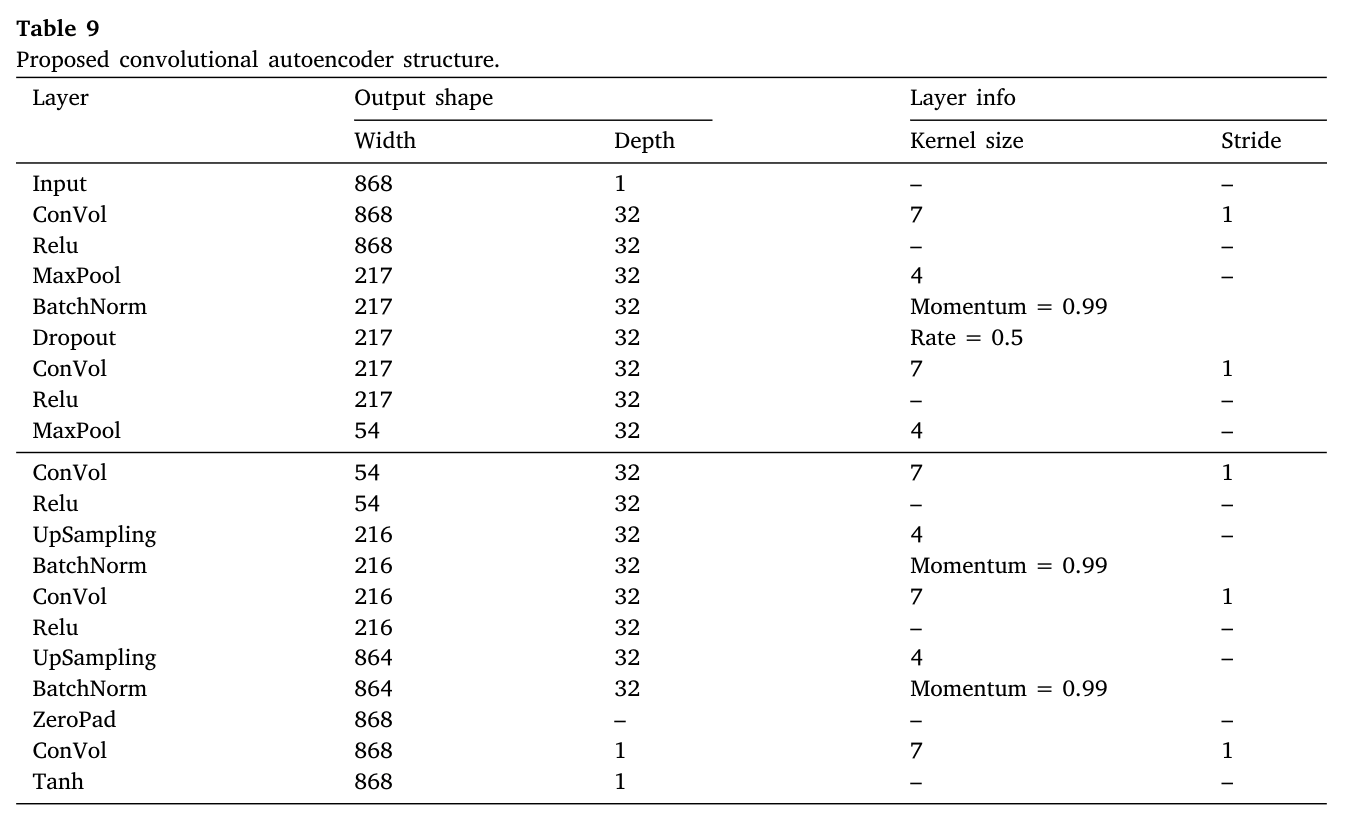

In [1247]:
model = keras.models.clone_model(model2)

In [1248]:
# training classifier CODE HERE
firstAct = 'relu'

model_bottleneck = Sequential(name='autoencoder')

model_bottleneck.add(Conv1D(32,(7), strides=1, padding='same', activation=firstAct))
model_bottleneck.add(MaxPool1D(4,padding='same'))
model_bottleneck.add(BatchNormalization())
model_bottleneck.add(Dropout(0.5))

model_bottleneck.add(Conv1D(32,(7), strides=1, padding='same', activation=firstAct))
# model_bottleneck.add(MaxPool1D(4,padding='same')) #remove maxpool layer

# following layers to be added after weight transfer
# model_bottleneck.add(UpSampling1D(2))

model_bottleneck.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [1249]:
model_bottleneck.build(model.input_shape) #building model to allow for weight transfer

In [1250]:
# get rid of decoder from the autoencoder
for i in range(8): #get rid of maxpool layer
    model._layers.pop(-1)

for i in model.trainable_weights:
    print(i.name)

conv1d_221/kernel:0
conv1d_221/bias:0
batch_normalization_130/gamma:0
batch_normalization_130/beta:0
conv1d_222/kernel:0
conv1d_222/bias:0


In [1251]:
# check to make sure we have the same layer remaining
for i in model.trainable_weights:
    print(i.name)

print('-----')

for i in model_bottleneck.trainable_weights:
    print(i.name)    

print('-----\n')
print('-----')

print(len(model.get_weights()), len(model_bottleneck.get_weights()))

conv1d_221/kernel:0
conv1d_221/bias:0
batch_normalization_130/gamma:0
batch_normalization_130/beta:0
conv1d_222/kernel:0
conv1d_222/bias:0
-----
conv1d_264/kernel:0
conv1d_264/bias:0
batch_normalization_152/gamma:0
batch_normalization_152/beta:0
conv1d_265/kernel:0
conv1d_265/bias:0
-----

-----
8 8


In [1252]:
# transfer weights
model_bottleneck.set_weights(model.get_weights())

In [1253]:
model.summary()

Model: "sequential_55"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_221 (Conv1D)          (None, 800, 32)           1152      
_________________________________________________________________
max_pooling1d_108 (MaxPoolin (None, 200, 32)           0         
_________________________________________________________________
batch_normalization_130 (Bat (None, 200, 32)           128       
_________________________________________________________________
dropout_54 (Dropout)         (None, 200, 32)           0         
_________________________________________________________________
conv1d_222 (Conv1D)          (None, 200, 32)           7200      
Total params: 8,480
Trainable params: 8,416
Non-trainable params: 64
_________________________________________________________________


In [1254]:
model_bottleneck.summary()

Model: "autoencoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_264 (Conv1D)          (None, 800, 32)           1152      
_________________________________________________________________
max_pooling1d_134 (MaxPoolin (None, 200, 32)           0         
_________________________________________________________________
batch_normalization_152 (Bat (None, 200, 32)           128       
_________________________________________________________________
dropout_74 (Dropout)         (None, 200, 32)           0         
_________________________________________________________________
conv1d_265 (Conv1D)          (None, 200, 32)           7200      
Total params: 8,480
Trainable params: 8,416
Non-trainable params: 64
_________________________________________________________________


In [1255]:
# freeze encoder layers
for layer in model_bottleneck.layers:
    layer.trainable = False

In [1256]:
# add decoder
model_bottleneck.add(UpSampling1D(2))

# add classifier
model_bottleneck.add(Flatten())
model_bottleneck.add(Dense(100, activation='relu'))
model_bottleneck.add(Dense(3, activation='softmax'))

model_bottleneck.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [1257]:
model_bottleneck.summary()

Model: "autoencoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_264 (Conv1D)          (None, 800, 32)           1152      
_________________________________________________________________
max_pooling1d_134 (MaxPoolin (None, 200, 32)           0         
_________________________________________________________________
batch_normalization_152 (Bat (None, 200, 32)           128       
_________________________________________________________________
dropout_74 (Dropout)         (None, 200, 32)           0         
_________________________________________________________________
conv1d_265 (Conv1D)          (None, 200, 32)           7200      
_________________________________________________________________
up_sampling1d_91 (UpSampling (None, 400, 32)           0         
_________________________________________________________________
flatten_30 (Flatten)         (None, 12800)             

In [1258]:
tempX = train_X
tempy = train_y.T.to_numpy()[np.newaxis,:].T
tempy = to_categorical(tempy).reshape(450,3) #one hot encode to match the softmax layer

tempX.shape, tempy.shape

((450, 800, 5), (450, 3))

In [1259]:
bottleneck_history = model_bottleneck.fit(tempX, tempy, epochs=50)

Epoch 1/50
15/15 [==============================] - 1s 4ms/step - loss: 1.5192 - accuracy: 0.3769
Epoch 2/50
15/15 [==============================] - 0s 3ms/step - loss: 0.9257 - accuracy: 0.6881
Epoch 3/50
15/15 [==============================] - 0s 3ms/step - loss: 0.8227 - accuracy: 0.6014
Epoch 4/50
15/15 [==============================] - 0s 4ms/step - loss: 0.6821 - accuracy: 0.7473
Epoch 5/50
15/15 [==============================] - 0s 4ms/step - loss: 0.6266 - accuracy: 0.7950
Epoch 6/50
15/15 [==============================] - 0s 4ms/step - loss: 0.5807 - accuracy: 0.7790
Epoch 7/50
15/15 [==============================] - 0s 3ms/step - loss: 0.5197 - accuracy: 0.9144
Epoch 8/50
15/15 [==============================] - 0s 4ms/step - loss: 0.4730 - accuracy: 0.8883
Epoch 9/50
15/15 [==============================] - 0s 3ms/step - loss: 0.4253 - accuracy: 0.8734
Epoch 10/50
15/15 [==============================] - 0s 4ms/step - loss: 0.3901 - accuracy: 0.8753
Epoch 11/50
15/15 [

In [1260]:
tempX = test_X
tempy = test_y.T.to_numpy()[np.newaxis,:].T
tempy = to_categorical(tempy).reshape(50,3) #one hot encode test labels

tempX.shape, tempy.shape

((50, 800, 5), (50, 3))

In [1261]:
_, acc = model_bottleneck.evaluate(tempX, tempy, verbose=True)
print(f'Test Accuracy: {acc * 100}')

2/2 [==============================] - 0s 7ms/step - loss: 1.2616 - accuracy: 0.5600
Test Accuracy: 56.00000023841858


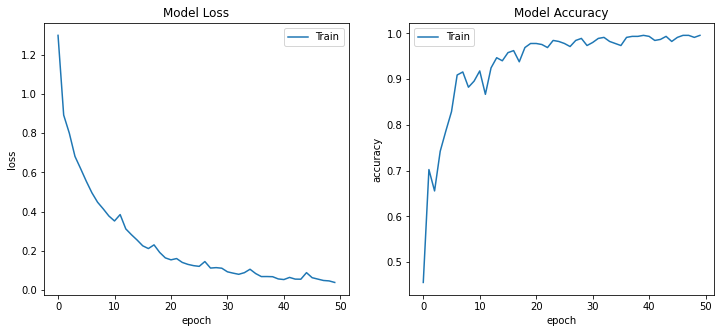

In [1262]:
fig, axs = plt.subplots(1,2, figsize=(6*2,5))

axs[0].plot(bottleneck_history.history['loss'], label='Train')
axs[0].set_title('Model Loss')
axs[0].set_ylabel('loss')
axs[0].set_xlabel('epoch')
axs[0].legend()

axs[1].plot(bottleneck_history.history['accuracy'], label='Train')
axs[1].set_title('Model Accuracy')
axs[1].set_ylabel('accuracy')
axs[1].set_xlabel('epoch')
axs[1].legend()

In [1263]:
for i in range(3): #get rid of maxpool layer
    model_bottleneck._layers.pop(-1)

In [1264]:
model_bottleneck.summary()

Model: "autoencoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_264 (Conv1D)          (None, 800, 32)           1152      
_________________________________________________________________
max_pooling1d_134 (MaxPoolin (None, 200, 32)           0         
_________________________________________________________________
batch_normalization_152 (Bat (None, 200, 32)           128       
_________________________________________________________________
dropout_74 (Dropout)         (None, 200, 32)           0         
_________________________________________________________________
conv1d_265 (Conv1D)          (None, 200, 32)           7200      
_________________________________________________________________
up_sampling1d_91 (UpSampling (None, 400, 32)           0         
Total params: 8,480
Trainable params: 0
Non-trainable params: 8,480
_____________________________________________________

**TASK 6 (25 points) (Modifying bottleneck of auto-encoder PART 2)**: In this part, you will insert two dense layers in the middle of original auto-encoder to ensure K is precisely equals to 434.
If K' was the encoding dimension of original auto-encoder, first dense layer maps K' dimension vector to K dimension. Second dense layer maps K dimension to K'.

Again, like previous tasks, first train the autoencoder, then train the subsequent classifier (keeping encoder frozen), and finally report test accuracy. The classifier architecture remains same as before. Also, display a test image and its reconstruction using this auto-encoder. What is your comment on it (especially in comparison to your TASK 5 figure)?

Hint: Performance and reconstruction is poorer for this part due to increased network complexity and loss of 2D structure by flattening operation (required for dense layers).

In [1519]:
model = keras.models.clone_model(model2)

In [1544]:
# Custom CNN Model (There are 3 Conv-MaxPool operations)
firstAct = 'relu'

model_bot2 = Sequential()
model_bot2.add(Conv1D(32,(7), strides=1, padding='same', activation=firstAct))
model_bot2.add(MaxPool1D(4,padding='same'))
model_bot2.add(BatchNormalization())
model_bot2.add(Dropout(0.5))

model_bot2.add(Conv1D(32,(7), strides=1, padding='same', activation=firstAct))
model_bot2.add(MaxPool1D(4,padding='same'))

#two dense layers added in the middle of the autoencoder
model_bot2.add(Dense(434,activation=firstAct))
model_bot2.add(Dense(32,activation=firstAct))

model_bot2.add(Conv1D(32,(7), strides=1, padding='same', activation=firstAct))
model_bot2.add(UpSampling1D(4))
model_bot2.add(BatchNormalization())

model_bot2.add(Conv1D(32,(7), strides=1, padding='same', activation=firstAct))
model_bot2.add(UpSampling1D(4))
model_bot2.add(BatchNormalization())

In [1545]:
model_bot2.build(model.input_shape) #building model to allow for weight transfer

In [1546]:
model_bot2.layers[6].trainable=False
model_bot2.layers[7].trainable=False

In [1547]:
model_bot2.summary()

Model: "sequential_91"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_354 (Conv1D)          (None, 800, 32)           1152      
_________________________________________________________________
max_pooling1d_183 (MaxPoolin (None, 200, 32)           0         
_________________________________________________________________
batch_normalization_217 (Bat (None, 200, 32)           128       
_________________________________________________________________
dropout_99 (Dropout)         (None, 200, 32)           0         
_________________________________________________________________
conv1d_355 (Conv1D)          (None, 200, 32)           7200      
_________________________________________________________________
max_pooling1d_184 (MaxPoolin (None, 50, 32)            0         
_________________________________________________________________
dense_150 (Dense)            (None, 50, 434)         

In [1548]:
model.layers

In [1549]:
model_bot2.layers

In [1550]:
# transfer weights
idx = 0
for i, layer in enumerate(model_bot2.layers):
    if layer.trainable == True:
        layer.set_weights(model.layers[idx].get_weights())
        idx += 1

In [1551]:
# unfreeze dense layers and freeze all other layers
for layer in model_bot2.layers:
    layer.trainable = False

model_bot2.layers[6].trainable = True
model_bot2.layers[7].trainable = True

In [1552]:
model_bot2.summary()

Model: "sequential_91"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_354 (Conv1D)          (None, 800, 32)           1152      
_________________________________________________________________
max_pooling1d_183 (MaxPoolin (None, 200, 32)           0         
_________________________________________________________________
batch_normalization_217 (Bat (None, 200, 32)           128       
_________________________________________________________________
dropout_99 (Dropout)         (None, 200, 32)           0         
_________________________________________________________________
conv1d_355 (Conv1D)          (None, 200, 32)           7200      
_________________________________________________________________
max_pooling1d_184 (MaxPoolin (None, 50, 32)            0         
_________________________________________________________________
dense_150 (Dense)            (None, 50, 434)         

In [1553]:
# check to make sure we have the same layer remaining
for i in model.trainable_weights:
    print(i.name)

print('-----')

for i in model_bot2.trainable_weights:
    print(i.name)    

print('-----\n')
print('-----')

print(len(model.get_weights()), len(model_bottleneck.get_weights()))

conv1d_221/kernel:0
conv1d_221/bias:0
batch_normalization_130/gamma:0
batch_normalization_130/beta:0
conv1d_222/kernel:0
conv1d_222/bias:0
conv1d_223/kernel:0
conv1d_223/bias:0
batch_normalization_131/gamma:0
batch_normalization_131/beta:0
conv1d_224/kernel:0
conv1d_224/bias:0
batch_normalization_132/gamma:0
batch_normalization_132/beta:0
conv1d_225/kernel:0
conv1d_225/bias:0
-----
dense_150/kernel:0
dense_150/bias:0
dense_151/kernel:0
dense_151/bias:0
-----

-----
22 8


In [1554]:
# add classifier
model_bot2.add(Flatten())
model_bot2.add(Dense(100, activation='relu'))
model_bot2.add(Dense(3, activation='softmax'))

model_bottleneck.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [1555]:
model_bot2.summary()

Model: "sequential_91"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_354 (Conv1D)          (None, 800, 32)           1152      
_________________________________________________________________
max_pooling1d_183 (MaxPoolin (None, 200, 32)           0         
_________________________________________________________________
batch_normalization_217 (Bat (None, 200, 32)           128       
_________________________________________________________________
dropout_99 (Dropout)         (None, 200, 32)           0         
_________________________________________________________________
conv1d_355 (Conv1D)          (None, 200, 32)           7200      
_________________________________________________________________
max_pooling1d_184 (MaxPoolin (None, 50, 32)            0         
_________________________________________________________________
dense_150 (Dense)            (None, 50, 434)         

In [1556]:
tempX = train_X
tempy = train_y.T.to_numpy()[np.newaxis,:].T
tempy = to_categorical(tempy).reshape(450,3) #one hot encode to match the softmax layer

tempX.shape, tempy.shape

((450, 800, 5), (450, 3))

In [1557]:
bottleneck_history = model_bottleneck.fit(tempX, tempy, epochs=50)

Epoch 1/50
15/15 [==============================] - 1s 3ms/step - loss: 7.9626 - accuracy: 0.3935
Epoch 2/50
15/15 [==============================] - 0s 3ms/step - loss: 8.0804 - accuracy: 0.4086
Epoch 3/50
15/15 [==============================] - 0s 4ms/step - loss: 8.0776 - accuracy: 0.3884
Epoch 4/50
15/15 [==============================] - 0s 3ms/step - loss: 7.6666 - accuracy: 0.4136
Epoch 5/50
15/15 [==============================] - 0s 3ms/step - loss: 8.3274 - accuracy: 0.3505
Epoch 6/50
15/15 [==============================] - 0s 3ms/step - loss: 8.0761 - accuracy: 0.3924
Epoch 7/50
15/15 [==============================] - 0s 3ms/step - loss: 8.2385 - accuracy: 0.3802
Epoch 8/50
15/15 [==============================] - 0s 4ms/step - loss: 8.4303 - accuracy: 0.3811
Epoch 9/50
15/15 [==============================] - 0s 3ms/step - loss: 7.3889 - accuracy: 0.4283
Epoch 10/50
15/15 [==============================] - 0s 3ms/step - loss: 8.3561 - accuracy: 0.3874
Epoch 11/50
15/15 [

In [1558]:
tempX = test_X
tempy = test_y.T.to_numpy()[np.newaxis,:].T
tempy = to_categorical(tempy).reshape(50,3) #one hot encode test labels

tempX.shape, tempy.shape

((50, 800, 5), (50, 3))

In [1559]:
_, acc = model_bottleneck.evaluate(tempX, tempy, verbose=True)
print(f'Test Accuracy: {acc * 100}')

2/2 [==============================] - 0s 8ms/step - loss: 4.5933 - accuracy: 0.5000
Test Accuracy: 50.0


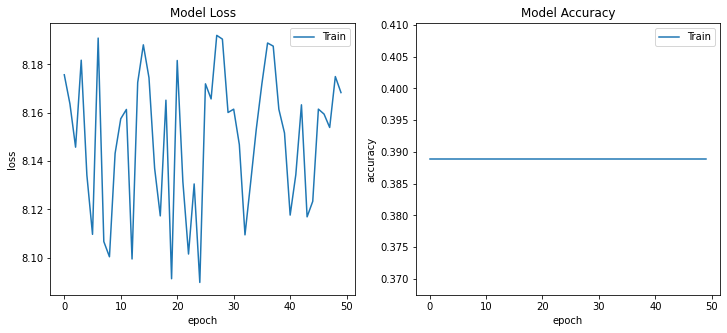

In [1560]:
fig, axs = plt.subplots(1,2, figsize=(6*2,5))

axs[0].plot(bottleneck_history.history['loss'], label='Train')
axs[0].set_title('Model Loss')
axs[0].set_ylabel('loss')
axs[0].set_xlabel('epoch')
axs[0].legend()

axs[1].plot(bottleneck_history.history['accuracy'], label='Train')
axs[1].set_title('Model Accuracy')
axs[1].set_ylabel('accuracy')
axs[1].set_xlabel('epoch')
axs[1].legend()

**BONUS (20 points)**:

Suggest a *much simpler scheme* to reduce dimension of encoding while ensuring performance does not drop. That is, performance should be still >90%.

OR

Plot t-SNE visualization (https://opentsne.readthedocs.io/) of the representations of training data learned by the auto-encoders of PART 2, 5, and 6. Use different color for data from different classes. Comment on your results.

In [1563]:
%pip install opentsne

     |████████████████████████████████| 2.3MB 10.0MB/s 


In [1567]:
from openTSNE import TSNE
from openTSNE.callbacks import ErrorLogger

# from examples import utils

import numpy as np
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt

In [1596]:
# tsne = TSNE()
tsne = TSNE(
    perplexity=30,
    metric="euclidean",
    callbacks=ErrorLogger(),
    n_jobs=8,
    random_state=12345,
)

/usr/local/lib/python3.7/dist-packages/openTSNE/callbacks.py:55: FutureWarning: `ErrorLogger` will be removed in upcoming version. Please use the `verbose` flag instead.
  category=FutureWarning,


In [1597]:
df.to_numpy()

array([[ 0.1025641 ,  0.44660194, -0.20670391, ...,  0.14361702,
         0.59416446, -0.01438849],
       [ 0.15384615,  0.53398058, -0.12290503, ...,  0.14539007,
         0.52785146, -0.05755396],
       [ 0.25641026,  0.5       , -0.09497207, ...,  0.14539007,
         0.39522546, -0.1942446 ],
       ...,
       [ 0.61538462, -0.17475728,  0.16201117, ...,  0.55585106,
        -0.68435013, -0.45323741],
       [ 0.55128205, -0.25728155,  0.20111732, ...,  0.54078014,
        -0.58090186, -0.21582734],
       [ 0.35897436, -0.13592233,  0.22905028, ...,  0.52216312,
        -0.47480106, -0.15827338]])

In [1598]:
df

,O044.txt,O082.txt,Z003.txt,N060.TXT,N011.TXT,F099.txt,S040.txt,O060.txt,S051.txt,Z077.txt,F088.txt,N033.TXT,Z066.txt,F065.txt,N017.TXT,Z036.txt,O046.txt,N047.TXT,F087.txt,N029.TXT,Z078.txt,O070.txt,Z029.txt,F062.txt,F016.txt,F026.txt,S010.txt,Z083.txt,Z063.txt,N043.TXT,N087.TXT,F089.txt,Z044.txt,F091.txt,N010.TXT,F027.txt,S033.txt,F029.txt,N083.TXT,S053.txt,...,Z042.txt,Z043.txt,S006.txt,N086.TXT,F038.txt,F001.txt,N077.TXT,O075.txt,F054.txt,Z072.txt,Z076.txt,O030.txt,S085.txt,O023.txt,N056.TXT,S078.txt,Z056.txt,F022.txt,S002.txt,O019.txt,Z059.txt,O043.txt,O007.txt,Z001.txt,Z032.txt,Z075.txt,S074.txt,N095.TXT,N018.TXT,Z019.txt,S009.txt,S059.txt,S013.txt,O050.txt,S023.txt,F094.txt,O058.txt,F060.txt,S063.txt,Z087.txt
0,0.102564,0.446602,-0.206704,-0.252964,0.290598,0.048077,0.524954,0.394089,0.226852,0.360759,-0.047619,-0.121495,-0.151515,0.257576,-0.413793,0.235294,0.262745,0.065134,0.438202,-0.189744,-0.046784,0.050980,-0.253012,-0.086643,-0.551136,-0.031579,0.198408,-0.307692,-0.338983,-0.442857,0.025424,0.149306,-0.323944,0.340206,-0.297101,-0.089362,0.190308,0.043478,-0.398734,0.121429,...,-0.582734,-0.165217,-0.245810,-0.028846,-0.112360,0.295652,0.071429,0.486339,-0.183333,0.801418,0.24375,-0.145833,0.113022,0.026596,-0.100000,-0.389011,0.321678,0.104,0.187225,0.047945,-0.148148,0.012658,-0.179931,0.063158,-0.450549,0.142857,-0.054688,0.158333,0.208633,0.000000,-0.339029,-0.310210,0.489823,-0.212766,0.036193,-0.225275,-0.225806,0.143617,0.594164,-0.014388
1,0.153846,0.533981,-0.122905,-0.221344,0.264957,0.019231,0.661738,0.270936,0.203704,0.518987,0.000000,-0.098131,-0.232323,0.191919,-0.482759,0.352941,0.364706,0.084291,0.460674,-0.179487,-0.111111,-0.054902,-0.295181,-0.054152,-0.517045,-0.031579,-0.108753,-0.302198,-0.279661,-0.471429,0.025424,0.229167,-0.309859,0.391753,-0.253623,-0.063830,0.160352,0.046699,-0.386076,0.127551,...,-0.568345,0.078261,-0.321229,0.038462,-0.179775,0.286957,-0.059006,0.311475,-0.196667,0.914894,0.25625,-0.154167,-0.098280,-0.159574,-0.124138,-0.520879,0.293706,0.116,0.194383,0.010274,-0.170370,0.012658,-0.193772,0.115789,-0.406593,0.059524,-0.044271,0.233333,0.194245,0.018519,-0.340827,-0.279922,0.454366,-0.177305,0.073727,-0.225275,-0.147465,0.145390,0.527851,-0.057554
2,0.256410,0.500000,-0.094972,-0.205534,0.247863,-0.057692,0.225508,0.073892,0.175926,0.588608,0.079365,-0.037383,-0.252525,0.171717,-0.536050,0.435294,0.439216,0.072797,0.460674,-0.205128,-0.187135,-0.196078,-0.222892,-0.018051,-0.420455,-0.073684,-0.462069,-0.291209,-0.135593,-0.500000,0.050847,0.354167,-0.330986,0.419244,-0.202899,0.008511,0.128634,0.049919,-0.379747,0.131633,...,-0.546763,0.304348,-0.391061,0.173077,-0.196629,0.243478,-0.226708,0.120219,-0.213333,0.765957,0.26875,-0.133333,-0.349509,-0.297872,-0.175862,-0.584615,0.202797,0.104,0.220264,-0.047945,-0.177778,0.056962,-0.169550,0.184211,-0.318681,-0.053571,-0.041667,0.312500,0.143885,-0.009259,-0.356115,-0.256473,0.369009,-0.085106,0.100536,-0.263736,-0.170507,0.145390,0.395225,-0.194245
3,0.314103,0.310680,-0.134078,-0.260870,0.162393,-0.038462,-0.210721,0.137931,0.136574,0.430380,0.063492,0.028037,-0.232323,0.242424,-0.636364,0.411765,0.486275,0.080460,0.471910,-0.158974,-0.233918,-0.274510,-0.072289,-0.003610,-0.301136,-0.031579,-0.702918,-0.318681,0.127119,-0.414286,0.101695,0.482639,-0.281690,0.453608,-0.166667,0.080851,0.112775,0.048309,-0.335443,0.136735,...,-0.474820,0.321739,-0.444134,0.230769,-0.292135,0.191304,-0.338509,0.098361,-0.256667,0.425532,0.22500,-0.087500,-0.465602,-0.430851,-0.172414,-0.628571,0.139860,0.088,0.258811,-0.092466,-0.177778,0.139241,-0.176471,0.236842,-0.406593,-0.107143,-0.039062,0.354167,0.071942,0.129630,-0.402878,-0.284319,0.262640,0.120567,0.120643,-0.263736,-0.179724,0.136525,0.177719,-0.309353
4,0.352564,0.228155,-0.173184,-0.249012,0.136752,-0.086538,-0.574861,0.133005,0.092593,0.145570,0.095238,0.130841,-0.181818,0.262626,-0.583072,0.394118,0.403922,0.038314,0.483146,-0.123077,-0.321637,-0.423529,0.000000,0.014440

In [1599]:
tsne_embedding = tsne.fit(df.to_numpy().T)

Iteration   50, KL divergence  2.8703, 50 iterations in 0.8699 sec
Iteration  100, KL divergence  2.9207, 50 iterations in 0.7922 sec
Iteration  150, KL divergence  3.0352, 50 iterations in 0.7977 sec
Iteration  200, KL divergence  3.0906, 50 iterations in 0.8029 sec
Iteration  250, KL divergence  2.8947, 50 iterations in 0.8049 sec
Iteration   50, KL divergence  1.4749, 50 iterations in 0.7975 sec
Iteration  100, KL divergence  1.4217, 50 iterations in 0.7940 sec
Iteration  150, KL divergence  1.4053, 50 iterations in 0.7879 sec
Iteration  200, KL divergence  1.4010, 50 iterations in 0.7881 sec
Iteration  250, KL divergence  1.4004, 50 iterations in 0.8039 sec
Iteration  300, KL divergence  1.4002, 50 iterations in 0.7793 sec
Iteration  350, KL divergence  1.4008, 50 iterations in 0.7838 sec
Iteration  400, KL divergence  1.3999, 50 iterations in 0.7971 sec
Iteration  450, KL divergence  1.4006, 50 iterations in 0.7897 sec
Iteration  500, KL divergence  1.4005, 50 iterations in 0.7755

In [1600]:
tsne_embedding.shape

(500, 2)

In [1619]:
df_y.to_numpy().T.shape

(500, 1)

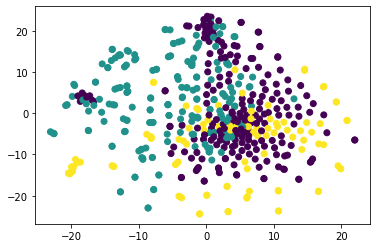

In [1620]:
mlp = plt.scatter(x=tsne_embedding[:,0],y=tsne_embedding[:,1],c=df_y.to_numpy().T)

There seem to be 3 distinguishable segments of classes. Interestingly, there are three points where clusters form where largest cluster is consisting of all three classes. On the other hand, the other two clusters seem to be mostly formed by the purple class which presumably is the ictal class suggestive of distintive difference from the other two classes. 